# Helping chemists design selective JAK inhibitors

In [1]:
# Run this first. Note: Kernel will be restarted automatically. Ignore "session crashed" message.
!pip install -q condacolab
import condacolab
condacolab.install()


⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:36
🔁 Restarting kernel...


In [2]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [3]:
%%capture
!conda install rdkit

In [117]:
!pip install wandb -qqq
import wandb
wandb.login()
import os
os.environ['WANDB_CONSOLE'] = 'off'

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# The dataset

Here's the kinase dataset we'd like you to work with:

In [22]:
import pandas as pd
import numpy as np
url='https://raw.githubusercontent.com/sronen71/ml-challenge/main/kinase_JAK.csv'
#df = pd.read_csv('./kinase_JAK.csv')
df=pd.read_csv(url)
df.head()
df.groupby(['measurement_type']).count()

,SMILES,measurement_value,Kinase_name
measurement_type,,,
pIC50,8736,8736,8736
pKi,1989,1989,1989


There are 10725 measurements in total.

SMILES is a text encoding of a molecular structure. You can read about it [here](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html), but you don't have to. 

measurement_type specifies how the measurement was being done. There are two types of measurements: pIC50 and pKi. For both measurements, a higher number means that the molecule binds stronger to the protein. 


measurement_value is the value of the measurement. 

Kinase_name is the name of the kinase that the molecule has been measured against. There are 4 different kinases in this dataset: JAK1, JAK2, JAK3, and TYR2. 

Our goal is to predict the pKi of a molecule against JAK1, JAK2, JAK3, and TYK2. 

# Basic RDKit¶


rdkit is the most popular cheminformatics package for python. Unfortunately it has awful documentation: http://rdkit.org/docs/index.html

In [23]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (400, 300)
# IPythonConsole.ipython_useSVG=True

You can use it to visualize SMILES strings like this, if you want to visually inspect the data:


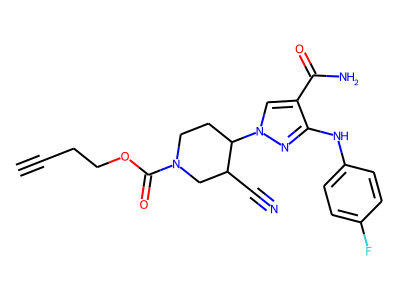

In [24]:
# Chem.MolFromSmiles returns a Chem.Mol object, which rdkit automatically visualizes in a jupyter notebook
Chem.MolFromSmiles(df['SMILES'][0])

# Tokenization

For text-based models, here is a tokenizer that can be used

In [25]:
def smiles_tokenizer(smi):
    """ 
    Tokenize a SMILES string representation of a molecule
    Returns a list of tokens in SMILES vocabulary
    """
    import re
    pattern =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]
    assert smi == ''.join(tokens)
    return tokens

In [26]:
df_pIC50 = df[df['measurement_type']=='pIC50']
df_pKi   = df[df['measurement_type']=='pKi'].sample(frac=1)



In [27]:
def pivot(df):
    dfp=df.pivot(index='SMILES',columns=['Kinase_name','measurement_type'],values='measurement_value')
    return dfp.sort_index(axis=1,level=[1,0])


In [57]:
#N=df_pKi.shape[0]
#ntest=int(0.2*N)
#df_test = df_pKi.iloc[:ntest]
#df_train = pd.concat([df_pKi.iloc[ntest:],df_pIC50]).sample(frac=1)
#dfp_train = pivot(df_train)
#dfp_test = pivot(df_test)
#print(dfp_train.head())
#print(dfp_test.head())

dfp=pivot(df).sample(frac=1)


#u=dfp.index.to_series().str.strip().str[4].map(ord)
#dfp.iloc[:,:]=u.values[:,None]

pki=dfp.iloc[:,-4:].notna().any(axis=1)
dfp_pki = dfp[dfp.iloc[:,-4:].notna().any(axis=1)]
dfp_no_pki = dfp[dfp.iloc[:,-4:].isna().all(axis=1)]
N=pki[pki].shape[0]
ntest=int(0.2*N)
dfp_test = dfp_pki.iloc[:ntest]
dfp_train = pd.concat([dfp_pki.iloc[ntest:],dfp_no_pki])
print(dfp.shape)
print(dfp_test.shape)
print(dfp_train.shape)
print(dfp_test.count())
print(dfp_train.count())
print(dfp_train.std(axis=0,skipna=True))
print(dfp_test.std(axis=0,skipna=True))


(4528, 8)
(196, 8)
(4332, 8)
Kinase_name  measurement_type
JAK1         pIC50                 3
JAK2         pIC50                26
JAK3         pIC50                25
TYK2         pIC50                 1
JAK1         pKi                 141
JAK2         pKi                 156
JAK3         pKi                  57
TYK2         pKi                  32
dtype: int64
Kinase_name  measurement_type
JAK1         pIC50               3197
JAK2         pIC50               3038
JAK3         pIC50               1855
TYK2         pIC50                591
JAK1         pKi                  544
JAK2         pKi                  648
JAK3         pKi                  280
TYK2         pKi                  131
dtype: int64
Kinase_name  measurement_type
JAK1         pIC50               1.013914
JAK2         pIC50               0.921532
JAK3         pIC50               1.203424
TYK2         pIC50               0.675146
JAK1         pKi                 1.024500
JAK2         pKi                 1.144209
JAK

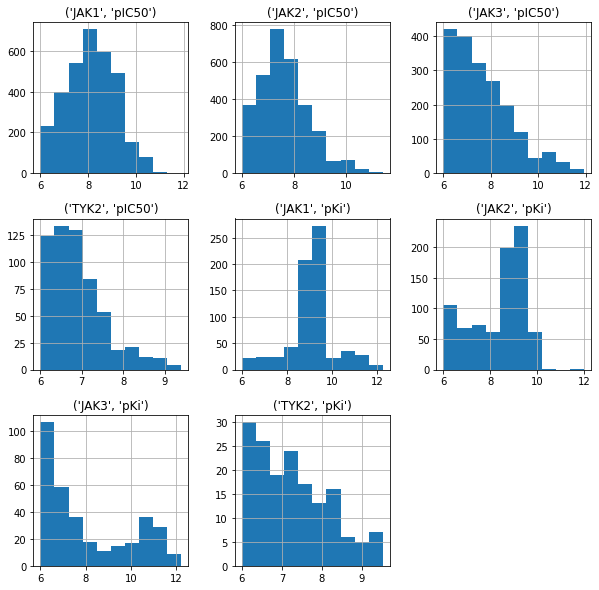

In [58]:
hist=dfp.hist(figsize=(10,10))

In [59]:
import torchtext
import torch

vocab = torchtext.vocab.build_vocab_from_iterator(map(smiles_tokenizer,df['SMILES']),specials=['<pad>'])
vocab.get_stoi()
PAD_IDX=0

In [60]:
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer



class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout,batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, 8)

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        padding_mask = (src == PAD_IDX)
        #padding_mask=None
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_key_padding_mask = padding_mask,mask=src_mask)
        output = self.decoder(output[:,0,:])
        return output

In [61]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:,:x.size(1)]
     
        return self.dropout(x)

In [62]:
max_string_len=100
def data_process(df):
  X = torch.zeros((df.shape[0],max_string_len),dtype=torch.long)
  for i,row in enumerate(df.itertuples()):
    u=vocab(smiles_tokenizer(row[0]))
    X[i,:len(u)] = torch.tensor(u,dtype=torch.long)
  
  Y = torch.tensor(df.values).float()
  dataset = torch.utils.data.TensorDataset(X, Y)
  return dataset

In [108]:
import torch
bptt=256
train_dataset = data_process(dfp_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bptt, shuffle=True,num_workers=2)
test_dataset = data_process(dfp_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False,num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")






In [145]:
ntokens = len(vocab) # the size of vocabulary
emsize = 128 # embedding dimension
nhid = 256 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 3 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value

model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [146]:
def proxy_loss(input, target):
    loss=target_loss(input,target)
    # Missing data are nan's
    input2=input[:,:-4]
    target2=target[:,:-4]
    # Missing data are nan's
    mask2 = torch.isnan(target2)
    out = (input2[~mask2]-target2[~mask2])**2
    loss += 0.5*out.sum()
    return loss

def target_loss(input, target):
    input1=input[:,-4:]
    target1=target[:,-4:]
    # Missing data are nan's
    mask1 = torch.isnan(target1)
    out = (input1[~mask1]-target1[~mask1])**2
    loss = out.sum()
    return loss

In [147]:
import time

proxy_criterion = proxy_loss
target_criterion = target_loss

lr = 0.001

optimizer = torch.optim.AdamW(model.parameters(),lr=lr)


def train(dataloader):
    model.train() # Turn on the train mode
    total_loss = 0.
    total_count = 0
    start_time = time.time()

    ibatch=0
    nbatches = len(dataloader)
    for local_batch, local_labels in dataloader:
        ibatch+=1
        # Transfer to GPU (if available)
        data, targets = local_batch.to(device), local_labels.to(device)
        optimizer.zero_grad()

        output = model(data, src_mask=None)
        loss = proxy_criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        total_count += torch.sum(~torch.isnan(targets)).item()
        cur_loss = total_loss / total_count
        log_interval = nbatches//2
        
        if ibatch % log_interval == 0 and ibatch > 0 or ibatch == nbatches-1:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | ms/batch {:5.2f} | loss {:5.2f}'.format(
                    epoch, ibatch, nbatches, scheduler.get_last_lr()[0],
                    elapsed * 1000 / log_interval, cur_loss))
            start_time = time.time()
    return cur_loss

def evaluate(dataloader):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    total_count = 0
    with torch.no_grad():
        for local_batch, local_labels in dataloader:
            data, targets = local_batch.to(device), local_labels.to(device)
            output = model(data, src_mask=None)
            total_loss += target_criterion(output, targets).item()
            total_count += torch.sum(~torch.isnan(targets)).item()
    return total_loss / total_count
    

In [148]:
best_val_loss = float("inf")
epochs = 60 # The number of epochs
best_model = None
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
wandb.init(
      project="kinase_challenege", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": lr,
      "dropout": dropout,
      "architecture": "Transformer",
      "dataset": "JAK Kinase",})
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    loss=train(train_dataloader)
    val_loss = evaluate(test_dataloader)
    wandb.log({"loss":loss, "eval": val_loss})
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f}'.format(epoch,(time.time() - epoch_start_time),val_loss))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()
wandb.finish()


| epoch   1 |     8/   17 batches | lr 0.0010 | ms/batch 116.06 | loss 20.25
| epoch   1 |    16/   17 batches | lr 0.0010 | ms/batch 91.19 | loss 15.50
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.82s | valid loss 21.69
-----------------------------------------------------------------------------------------
| epoch   2 |     8/   17 batches | lr 0.0010 | ms/batch 107.21 | loss  6.40
| epoch   2 |    16/   17 batches | lr 0.0010 | ms/batch 91.17 | loss  4.83
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  2.71s | valid loss  5.24
-----------------------------------------------------------------------------------------
| epoch   3 |     8/   17 batches | lr 0.0010 | ms/batch 106.09 | loss  1.21
| epoch   3 |    16/   17 batches | lr 0.0010 | ms/batch 91.27 | loss  0.94
---------------------------------------------------------------------------

loss,0.20562
eval,0.44239
_runtime,170
_timestamp,1627269391
_step,59


loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
